# Anniversary Analysis

## TOC:
* [Description](#description)
* [Parsing the info](#parsing_info)
    * [Facebook](#facebook)
    * [WhatsApp](#whatsapp)
* [Data Preparation](#preparation)
* [Data Exploration](#exploration)
    * [How many messages?](#how_many)
    * [Message exchange per day](#messages_day)
    * [Message exchange per week](#messages_week)
        * [Why FB gap in April?](#gap_april)
        * [Some FB landmarks](#fb_landmarks)
    * [Who said it first](#first)
    * [Who said it more?](#more)
    * [LOVE distribution per weeks](#love_weeks)
    * [Any preferred days to communicate?](#preferred_days)
    * [What about the hours?](#preferred_hours)
* [Further exploration: playing with words (NLP)](#nlp)
    * [Text normalization](#normalization)
    * [Word Frequency](#frequency)
        * [Bigrams](#bigrams)
        * [Trigrams](#trigrams)
    * [Sentiment analysis](#sentiment)
    * [Topic detection](#topic)
* [Annex](#annex)
    * [Normalize](#normalize)

## Description <a class="anchor" id="description"></a>

My partner and I met under very random circumstances. Some call it fate! ❤️

Anyway, after spending __only two__ days together we decided that our story couldn't end there. So, despite the fact that she went back to California, we tried to shorten the ~__6,000 mi__ (~9,500 km) that separeted us through online conversations.

We started using [Facebook Messenger](https://www.messenger.com/) for most of our communications. Then, we also started using [WhatsApp](https://www.whatsapp.com/), so there is a lot of data stored about us! 

As our first year anniversary is approaching, and because I'm a super data nerd, I decided to explore a little bit our conversations. 

This is not intended to be a sickeningly sweet Notebook. It's mostly a way to share how quickly one can obtain insights on data, but due to its nature you might find yourself involved into some rainbow stuff 🌈 🦄. 

General imports:

In [4]:
from bs4 import BeautifulSoup
import csv
import datetime as dt
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import gensim
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

## Parsing the info <a class="anchor" id="parsing_info"></a>

### Facebook <a class="anchor" id="facebook"></a>

Facebook includes an option that allows you to download __ALL__ the information you have ever shared in their platform.

In a folder called `messages` it stores all your Messenger conversations and files shared. The download consists of a set of `.html` files for every conversation you have ever had. 

The initial idea is to parse the `.html` files and store them into a `.csv` file to get rid of all unnecessary tags.

In [3]:
content_path = './messages/487.html'
f = open(content_path, 'r')
raw_content = f.read()
f.close()

In [4]:
soup = BeautifulSoup(raw_content, 'html.parser')

In [5]:
pretty_lines = soup.prettify().splitlines()

Exploring a little bit the document structure we realize that there is a lot of `css` content at the beginning.

In [6]:
pretty_lines[:5]

[u'<html>',
 u' <head>',
 u'  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>',
 u'  <base href="../"/>',
 u'  <style type="text/css">']

Spotting a message example we detect the flags `message`, `message_header` (containing the `user`), `meta` (the date) and the content of the message in a `p`element.

In [7]:
pretty_lines[149:164]

[u'   <div class="message">',
 u'    <div class="message_header">',
 u'     <span class="user">',
 u'      Guiem Bosch',
 u'     </span>',
 u'     <span class="meta">',
 u'      Saturday, January 6, 2018 at 9:35am UTC',
 u'     </span>',
 u'    </div>',
 u'   </div>',
 u'   <p>',
 u'    <p>',
 u'     <img src="messages/gifs/10155311765535197.gif"/>',
 u'    </p>',
 u'   </p>']

Finding all messages!

In [8]:
messages = soup.find_all("div", class_="message")

In [9]:
len(messages)

32767

In [20]:
for idx,m in enumerate(messages):
    if 'Guiem' in str(m):
        print(str(m))
    if idx == 10:
        break    

<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Saturday, January 6, 2018 at 9:35am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Saturday, January 6, 2018 at 9:34am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Saturday, January 6, 2018 at 9:34am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Saturday, January 6, 2018 at 9:33am UTC</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Thursday, October 5, 2017 at 6:31pm UTC+01</span></div></div>
<div class="message"><div class="message_header"><span class="user">Guiem Bosch</span><span class="meta">Thursday, October 5, 2017 at 6:31pm UTC+01</span></div></div>


__Ooops!__ Because the content of the message is not stored into the `div` element we cannot retrieve it. It looks like we are going to navigate down to the first `message` element and keep with the iteration.

In [10]:
thread = soup.find("div",class_="thread")

Dumping the cleaned data into a `.csv` file

In [38]:
outputcsv_path = './messages/messages.csv'
with open(outputcsv_path, 'w') as csvfile:
    fieldnames = ['user', 'date', 'text', 'source']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for idx, child in enumerate(thread.children):
        if child.name == 'div':
            message_header = child.find("div", class_='message_header')
            user = message_header.find("span", class_="user").get_text()
            date = message_header.find("span", class_="meta").get_text()
        elif child.name == 'p':
            li = child.find("li") # <li> element contains a Like to a specific message, we can discard it
            if li:
                li.extract()
            text = child.get_text()
            writer.writerow({'user': user.encode('utf-8'), 'date': date.encode('utf-8'), 'text': text.encode('utf-8'),
                            'source':'facebook'})

### WhatsApp <a class="anchor" id="whatsapp"></a>

WhatsApp allows you to send a specific chat conversation to an e-mail address. The result is a `.txt` file (note: one can choose to include the media files but it has been considered irrelevant in this case).

In [39]:
outputcsv_path = './messages/messages.csv'
file_paths = ['./messages/whatsapp1.txt','./messages/whatsapp2.txt']
with open(outputcsv_path, 'a') as csvfile:
    fieldnames = ['user', 'date', 'text', 'source']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    for f_path in file_paths:
        with open(f_path,'r') as f:
            for l in f.readlines():
                if len(l) > 0 and l[0].isdigit():
                    l = l.replace("+1 (626) 437-","J.") # one file contains her old number
                    if '-' in l:
                        date = l.split('-')[0].replace(',','').rstrip()
                        user_text = l.split('-')[1].split(':')
                        user = user_text[0].lstrip()
                        text = user_text[1].rstrip()
                        writer.writerow({'user': user, 'date': date,'text': text,'source':'whatsapp'})

## Data Preparation <a class="anchor" id="preparation"></a>

In [57]:
csv_data_path = './messages/messages.csv'
df = pd.read_csv(csv_data_path)

In [58]:
df['date'].dtype

dtype('O')

Dates are regular objects. We'll probably want to compare events in time. Let's convert them to `datetime` objects!

In [59]:
df['datetime'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['datetime'].dtype

dtype('<M8[ns]')

Also, to avoid unnecessary exposure, let's just obfuscate her name 😉

In [60]:
df.loc[df['user'].str.contains('J'),'user'] = 'J.'

In [61]:
df.user.unique()

array(['J.', 'Guiem Bosch'], dtype=object)

WhatsApp replaces media content by `<Media omitted>` if one has chosen to avoid media. We should clean this too.

In [62]:
df.loc[df['text'].str.contains('<Media omitted>',na=False),'text'] = np.nan

Facebook informs about video chat `The video chat ended` or `missed a video chat`.

In [63]:
df.loc[df['text'].str.contains('The video chat ended',na=False),'text'] = np.nan
df.loc[df['text'].str.contains('missed a video chat',na=False),'text'] = np.nan

Finally we save the dataframe as it is so we can load it anytime

In [64]:
csv_data_clean_path = './messages/messages_clean.csv'
df.to_csv(csv_data_clean_path,index=False)

Loading "prepared" data

In [3]:
csv_data_clean_path = './messages/messages_clean.csv'
parse_dates = ['datetime']
df = pd.read_csv(csv_data_clean_path, parse_dates = parse_dates)

## Data Exploration <a class="anchor" id="exploration"></a>

### How many messages? <a class="anchor" id="how_many"></a>

In [66]:
df.text.count()

75148

## OMG! 75,148 messages!

Back in the day, when my grandparents were taken apart due to war issues 😤  they would send a letter to each other every 6 months. 

Whereas us, in almost one year, exchanged ~75K text messages! Isn't that crazy? The postmodernism's culture of immediacy, I guess...  

### Message exchange per day <a class="anchor" id="messages_day"></a>

In [5]:
messages_day_f = df[df.source=='facebook'].groupby(pd.Grouper(key="datetime", freq='D')).count()

In [6]:
messages_day_w = df[df.source=='whatsapp'].groupby(pd.Grouper(key="datetime", freq='D')).count()

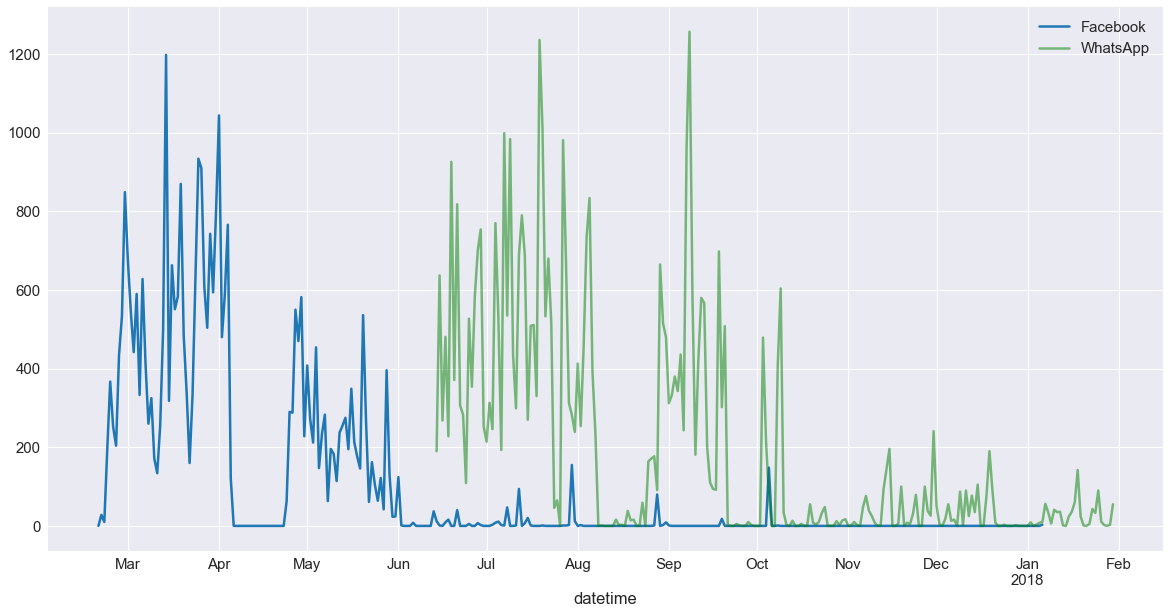

In [7]:
messages_day_f.text.plot(figsize=(20,10),label='Facebook')
messages_day_w.text.plot(figsize=(20,10),style='g',alpha=0.5,label='WhatsApp')
plt.legend(loc='best')

We can clearly observe a transition from Facebook Messenger to WhatsApp by mid June. We met by the start of June and I think she just saw I was using mostly WhatsApp to communicate with my friends...

### Message exchange per week <a class="anchor" id="messages_week"></a>

Day by day number of messages exchanged look a bit messy, what about gathering the info by weeks?

In [8]:
messages_week_f = df[df.source=='facebook'].groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

In [9]:
messages_week_w = df[df.source=='whatsapp'].groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

Text(50,50,'Trip Italy')

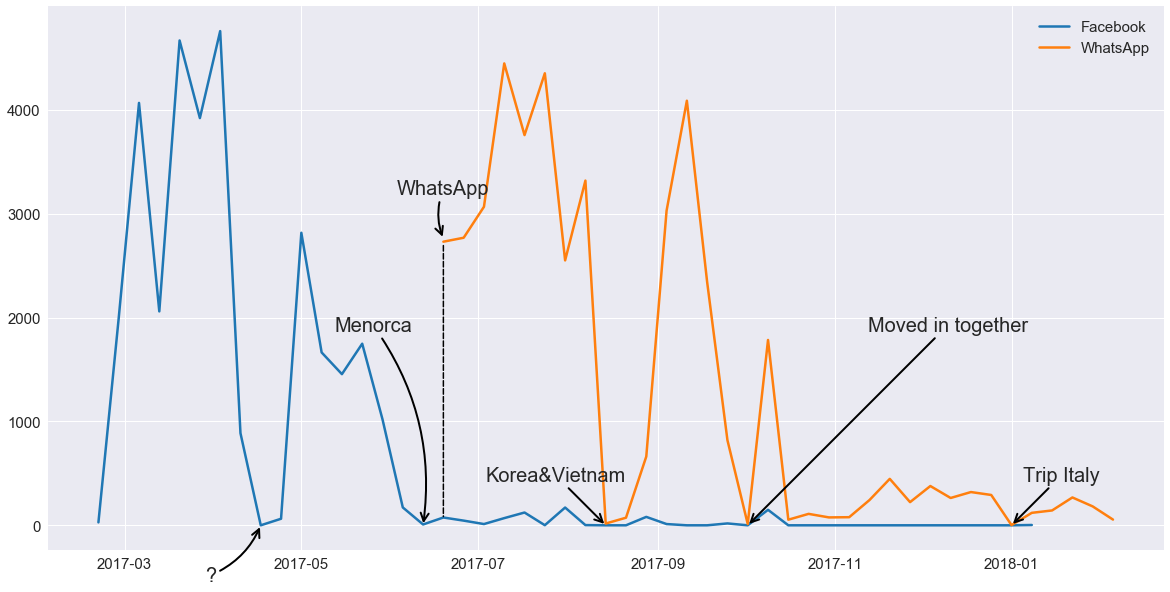

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
plt.plot(messages_week_f.text,label='Facebook')
plt.plot(messages_week_w.text,label='WhatsApp')
plt.legend(loc='best')
plt.annotate('?', (mdates.date2num(dt.datetime(2017,4,17)),0), xytext=(-50, -50),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.2",lw=2),
           )
plt.annotate('Menorca', (mdates.date2num(dt.datetime(2017,6,12)),0), xytext=(-50, 200),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2",lw=2),
           )
plt.annotate('WhatsApp', (mdates.date2num(dt.datetime(2017,6,19)),2759), xytext=(0, 50),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.2",
                            lw=2),
           )
plt.annotate('', (mdates.date2num(dt.datetime(2017,6,19)),65), xytext=(0, 275),
            textcoords='offset points', size=20, va="center",
            arrowprops=dict(arrowstyle="-",ls='dashed',lw=1.5),
           )
plt.annotate('Korea&Vietnam', (mdates.date2num(dt.datetime(2017,8,14)),0), xytext=(-50, 50),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )
plt.annotate('Moved in together', (mdates.date2num(dt.datetime(2017,10,2)),0), xytext=(200, 200),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )
plt.annotate('Trip Italy', (mdates.date2num(dt.datetime(2018,1,1)),0), xytext=(50, 50),
            textcoords='offset points', size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="->",lw=2),
           )

We observe that valleys in the communication graph depict "togetherness". Pretty obvious, right?! But what about the first gap...?

#### Why that FB gap in April? <a class="anchor" id="gap_april"></a>

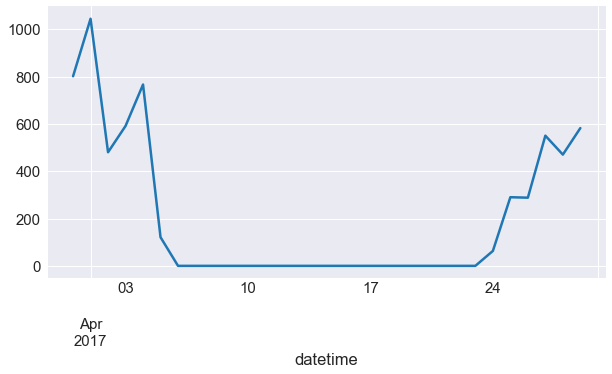

In [11]:
messages_day_f[40:70].text.plot(figsize=(10,5))

In [30]:
messages_day_f[40:70].text

datetime
2017-03-31     801
2017-04-01    1044
2017-04-02     480
2017-04-03     591
2017-04-04     766
2017-04-05     121
2017-04-06       0
2017-04-07       0
2017-04-08       0
2017-04-09       0
2017-04-10       0
2017-04-11       0
2017-04-12       0
2017-04-13       0
2017-04-14       0
2017-04-15       0
2017-04-16       0
2017-04-17       0
2017-04-18       0
2017-04-19       0
2017-04-20       0
2017-04-21       0
2017-04-22       0
2017-04-23       0
2017-04-24      63
2017-04-25     290
2017-04-26     288
2017-04-27     551
2017-04-28     470
2017-04-29     582
Freq: D, Name: text, dtype: int64

After verifying that some days definetly had null values for communication I went to investigate the raw data. I found that messages were missing for those days in the downloaded file but present when queried through the app. After downlading the data again and seeing no changesI notified this to Facebook. A bug maybe? 🤔

#### Some FB landmarks <a class="anchor" id="fb_landmarks"></a>

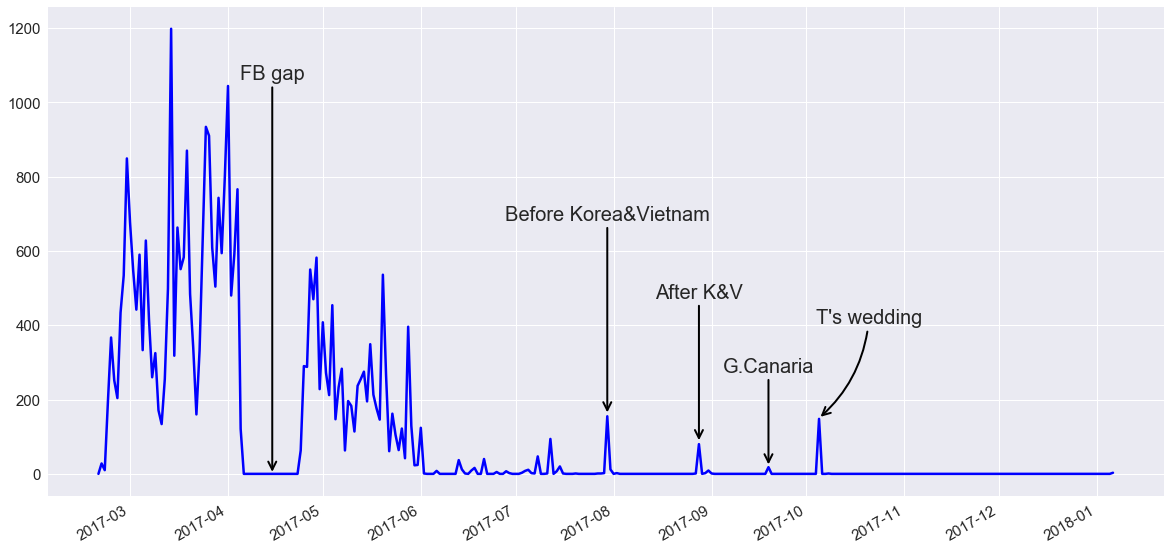

In [12]:
fig, ax = plt.subplots()
plt.plot(messages_day_f.text,'b')
fig.set_size_inches(20,10)
ax.annotate('FB gap', (mdates.date2num(dt.datetime(2017,4,15)),0), xytext=(0, 400),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('Before Korea&Vietnam', (mdates.date2num(dt.datetime(2017,7,30)),160), xytext=(0, 200),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('After K&V', (mdates.date2num(dt.datetime(2017,8,28)),85), xytext=(0, 150),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate('G.Canaria', (mdates.date2num(dt.datetime(2017,9,19)),20), xytext=(0, 100),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
ax.annotate("T's wedding", (mdates.date2num(dt.datetime(2017,10,5)),150), xytext=(50, 100),
            textcoords='offset points', size=20,
            va="center", ha="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2",
                             lw=2),
           )
fig.autofmt_xdate()

Peaks in communication usually anticipate moments when we were about to see each other 👀

### Who said it first? <a class="anchor" id="first"></a>

We know everything happened really fast, but who said "__I love you__" first? 

In [32]:
df[df['text'].str.contains("i love you", case=False) == True].sort_values(by='datetime').head(10)

,user,date,text,source,datetime
31867,Guiem Bosch,"Saturday, February 25, 2017 at 1:11pm UTC","""Hi, Jisu!\nI have to admit I've been contempl...",facebook,2017-02-25 13:11:00
31855,J.,"Saturday, February 25, 2017 at 1:32pm UTC","I hope you will, and maybe I'll come find you,...",facebook,2017-02-25 13:32:00
31837,J.,"Saturday, February 25, 2017 at 3:38pm UTC",I love your soul,facebook,2017-02-25 15:38:00
31627,J.,"Sunday, February 26, 2017 at 12:22am UTC","I love you, not in the traditional possessive ...",facebook,2017-02-26 00:22:00
31626,Guiem Bosch,"Sunday, February 26, 2017 at 12:23am UTC",I love you,facebook,2017-02-26 00:23:00
31624,Guiem Bosch,"Sunday, February 26, 2017 at 12:24am UTC",I love you because there is no alternative,facebook,2017-02-26 00:24:00
31559,Guiem Bosch,"Sunday, February 26, 2017 at 4:02am UTC",I love you!!!,facebook,2017-02-26 04:02:00
31422,J.,"Sunday, February 26, 2017 at 9:40pm UTC",I love you,facebook,2017-02-26 21:40:00
31318,Guiem Bosch,"Sunday, February 26, 2017 at 10:06pm UTC","I love you, Jisu",facebook,2017-02-26 22:06:00
31313,J.,"Sunday, February 26, 2017 at 10:07pm UTC","I love you, too, guiem!",facebook,2017-02-26 22:07:00


An alternative query to match with the exact words, to avoid cases like "__I love you__r soul"

In [33]:
love_tests = pd.Series(["I love you","i looooove you so much", "i love you!!!!", "i love youtube", "i love your soul"]) 

In [34]:
love_tests.str.contains(r"i lo+ve+ yo+u+\b.*", case=False)

0     True
1     True
2     True
3    False
4    False
dtype: bool

In [35]:
df[df['text'].str.contains(r"i lo+ve+ yo+u+\b.*", case=False) == True].sort_values(by='datetime').head(10)

,user,date,text,source,datetime
31867,Guiem Bosch,"Saturday, February 25, 2017 at 1:11pm UTC","""Hi, Jisu!\nI have to admit I've been contempl...",facebook,2017-02-25 13:11:00
31855,J.,"Saturday, February 25, 2017 at 1:32pm UTC","I hope you will, and maybe I'll come find you,...",facebook,2017-02-25 13:32:00
31627,J.,"Sunday, February 26, 2017 at 12:22am UTC","I love you, not in the traditional possessive ...",facebook,2017-02-26 00:22:00
31626,Guiem Bosch,"Sunday, February 26, 2017 at 12:23am UTC",I love you,facebook,2017-02-26 00:23:00
31624,Guiem Bosch,"Sunday, February 26, 2017 at 12:24am UTC",I love you because there is no alternative,facebook,2017-02-26 00:24:00
31559,Guiem Bosch,"Sunday, February 26, 2017 at 4:02am UTC",I love you!!!,facebook,2017-02-26 04:02:00
31422,J.,"Sunday, February 26, 2017 at 9:40pm UTC",I love you,facebook,2017-02-26 21:40:00
31318,Guiem Bosch,"Sunday, February 26, 2017 at 10:06pm UTC","I love you, Jisu",facebook,2017-02-26 22:06:00
31313,J.,"Sunday, February 26, 2017 at 10:07pm UTC","I love you, too, guiem!",facebook,2017-02-26 22:07:00
31197,J.,"Monday, February 27, 2017 at 9:03am UTC",I love you so much!!,facebook,2017-02-27 09:03:00


Awww, it was me! 😊

In [194]:
print(df.iloc[31867].text[-99:].replace("\n",""))

Okay, like it or not, this is the most honest I can be. And honesty is all I have. I love you."""


What about the first time she said it?

In [193]:
print(df.iloc[31855].text)

I hope you will, and maybe I'll come find you, too. You can't be the only one choosing the time and space. 😉 and I didn't know how to word all these intense crazy feelings and the most simple and the most universal way to tell you how I feel is reciprocal. I love you, too.


In [13]:
df_love = df[df['text'].str.contains(r"i lo+ve+ yo+u+\b.*", case=False) == True]

###  Love is not a competition, but who said it more? <a class="anchor" id="more"></a>

In [14]:
df_love.groupby("user")["user"].count()

user
Guiem Bosch    1229
J.             1628
Name: user, dtype: int64

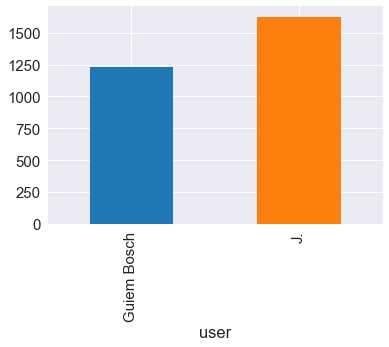

In [15]:
df_love.groupby("user")["user"].count().plot(kind='bar')

What about other ways to say it?

__Te quiero__

In [41]:
df[df['text'].str.contains(r"te quie+ro+\b.*", case=False) == True].groupby("user")["user"].count()

user
Guiem Bosch    62
J.             30
Name: user, dtype: int64

__Te amo__

In [42]:
df[df['text'].str.contains(r"te amo+\b.*", case=False) == True].groupby("user")["user"].count()

user
Guiem Bosch    25
J.             14
Name: user, dtype: int64

### LOVE distribution per weeks <a class="anchor" id="love_weeks"></a>

In [16]:
loves_week = df_love.groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

In [17]:
messages_week = df.groupby(pd.Grouper(key="datetime", freq='W-MON')).count()

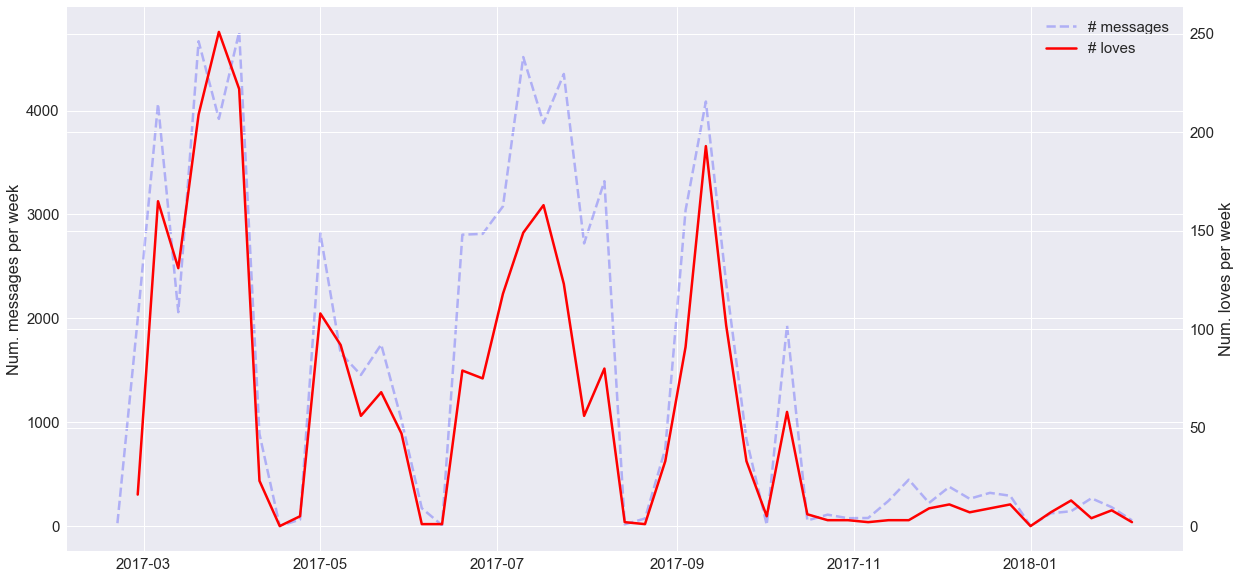

In [18]:
fig, ax = plt.subplots()
ax.plot(messages_week.text,'--',color='b',alpha=0.25,label='# messages')
ax.set_ylabel('Num. messages per week')
fig.set_size_inches(20,10)
ax2 = ax.twinx()
ax2.plot(loves_week.text,color='r',label='# loves')
ax2.set_ylabel('Num. loves per week')
lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='best')

It looks like there is a correlation between the number of messages exchanged and the number of times __love__ was  mentioned. Even though we are talking about different scales, the shape of the graphs is very similar!

Phew! If lots of messages were exchanged but no love talk involved we could probably be facing arguments. Awww, infatuation stage! 🗣️❤️

In [46]:
loves_week.text.corr(messages_week.text)

0.928193545097838

Wow, Pearson's correlation is __Too Damn High__!

Btw, beware that we are combining two scales! Real proportion:

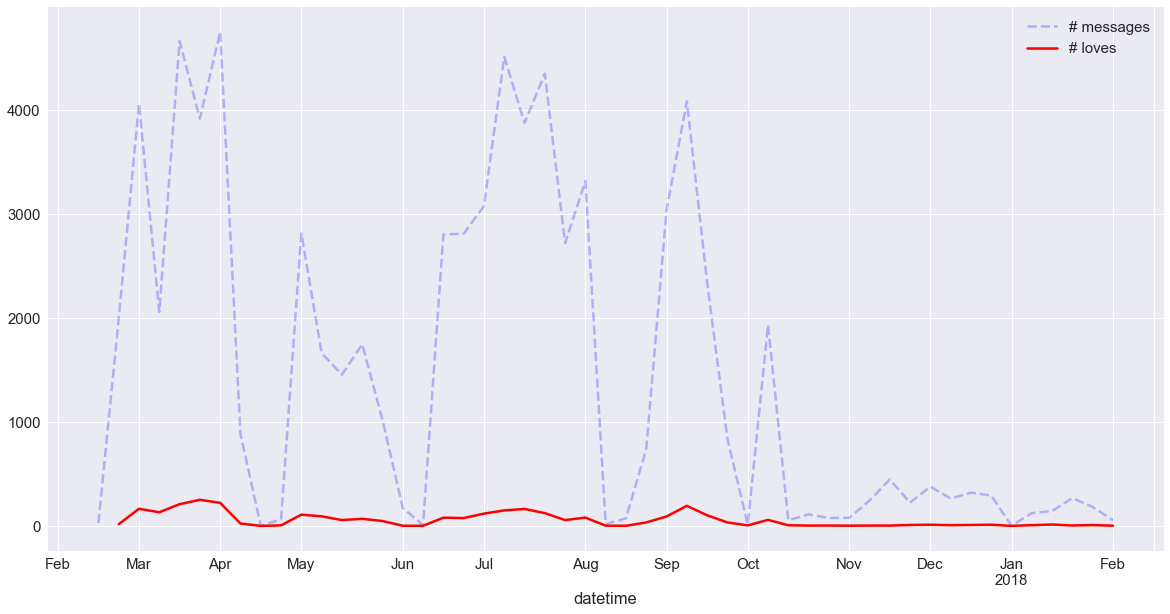

In [19]:
messages_week.text.plot(figsize=(20,10),style='--',color='b',alpha=0.25,label='# messages')
loves_week.text.plot(figsize=(20,10),color='r',label='# loves')
plt.legend(loc='best')

Wait! ~250 messages containing "I love you" __in a week__? Is that even possible?

In [48]:
loves_week.text.max()

251

In [49]:
loves_week.text.idxmax()

Timestamp('2017-03-27 00:00:00', offset='W-MON')

In [50]:
df_love_top_week = df_love[(df_love.datetime >= pd.datetime(2017,3,27)) & (df_love.datetime <= pd.datetime(2017,4,4))]

In [51]:
df_love_top_week.head()

,user,date,text,source,datetime
10918,J.,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!!!!!!,facebook,2017-04-03 23:58:00
10921,Guiem Bosch,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you sooo much,facebook,2017-04-03 23:58:00
10922,J.,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!!!!!!!💕❤️😘,facebook,2017-04-03 23:58:00
10925,Guiem Bosch,"Monday, April 3, 2017 at 10:58pm UTC+01",I love you!,facebook,2017-04-03 23:58:00
10932,J.,"Monday, April 3, 2017 at 10:56pm UTC+01",Baby I love you!!!!!,facebook,2017-04-03 23:56:00


In [52]:
df_love_top_week.tail()

,user,date,text,source,datetime
16052,Guiem Bosch,"Monday, March 27, 2017 at 9:28am UTC+01","hahaha, I love you!!!",facebook,2017-03-27 10:28:00
16077,J.,"Monday, March 27, 2017 at 7:07am UTC+01",I love you SO SO SO,facebook,2017-03-27 08:07:00
16086,Guiem Bosch,"Monday, March 27, 2017 at 7:05am UTC+01",I love you!!!,facebook,2017-03-27 08:05:00
16315,J.,"Monday, March 27, 2017 at 5:18am UTC+01",i love you so much. i wish i could see you rig...,facebook,2017-03-27 06:18:00
16332,Guiem Bosch,"Monday, March 27, 2017 at 12:05am UTC+01",I love you.,facebook,2017-03-27 01:05:00


Yeah... it looks like it's possible 😅

### Any preferred days to communicate? <a class="anchor" id="preferred_days"></a>

In [20]:
week_days = {0:'0 - Monday',1:'1 - Tuesday',2:'2 - Wednesday',3:'3 - Thursday',4:'4 - Friday',5:'5 - Saturday',6:'6 - Sunday'}
df['weekday'] = df['datetime'].apply(lambda x: week_days[x.weekday()])

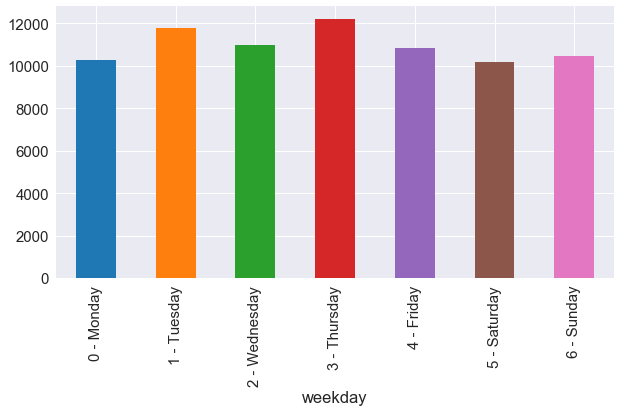

In [21]:
df.groupby('weekday')['datetime'].count().plot(kind='bar',figsize=(10,5))

Well, it doesn't look much significative (btw, what was happening on Tuesdays and Thursdays?)

### What about the hours? <a class="anchor" id="preferred_hours"></a>

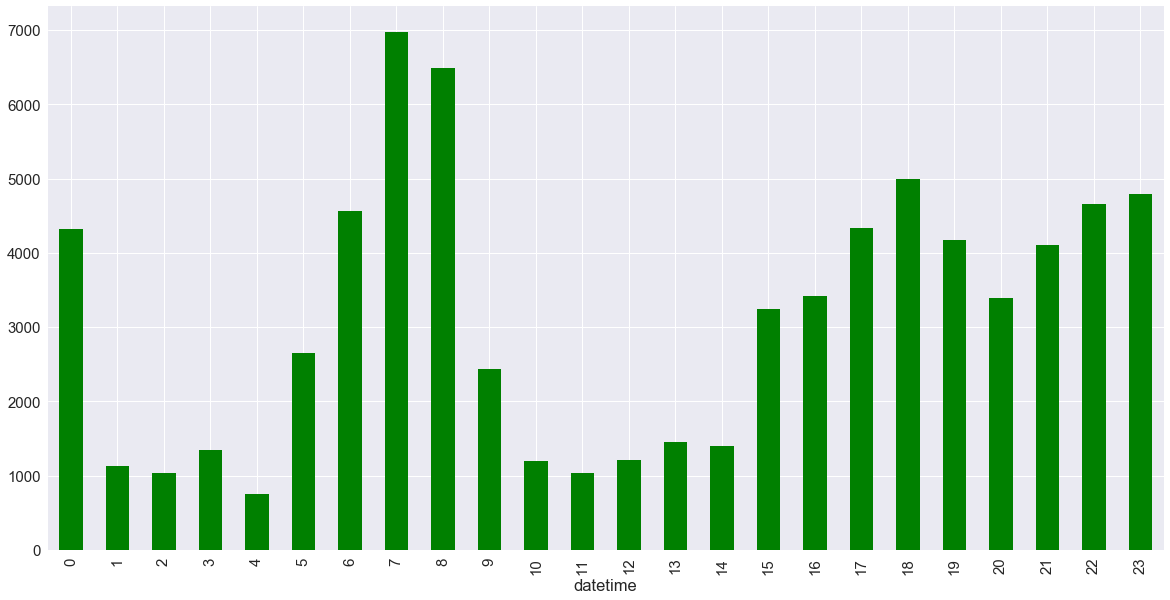

In [22]:
times = pd.DatetimeIndex(df.datetime)
df.groupby([times.hour]).text.count().plot(kind='bar',figsize=(20,10),color='g')

Timezones! ⏰   Ah, I would be usually 9hrs ahead of her time. We observe one peak at 7 a.m. (when I would wake up, her 10 p.m. of the previous day) and another peak around my 6 p.m. (her 9 a.m.). Basically we would communicate whenever one of us was waking up and the other was about to go to sleep and viceversa. Distance is tough when one's energy is 🌜 and the other's is ☀️   

## Playing with words (NLP) <a class="anchor" id="nlp"></a>

### Text normalization <a class="anchor" id="normalization"></a>

We perform de basic operations:
- Sentence tokenization
- Useful substitutions (i.e. contractions)
- Word tokenization
- Eliminating punctuation
- Conversion to lowercase
- Removing stop words
- Removing repetition

We defined a function called `normalize` that encapsulates all the previous operations 

In [54]:
df['text_normalized'] = df.text.apply(normalize)

### Word frequency <a class="anchor" id="frequency"></a>

In [56]:
df_with_text = df.text_normalized.dropna()

In [57]:
top_1000 = pd.Series(' '.join(df_with_text).split()).value_counts()[:1000]

In [105]:
heart_mask = np.array(Image.open("./imgs/heart_mask_2.png"))

In [106]:
stopwords = set()
wc = WordCloud(background_color="white",mask=heart_mask,stopwords=stopwords)

In [107]:
wc.generate_from_frequencies(list(top_1000.to_dict().items()))

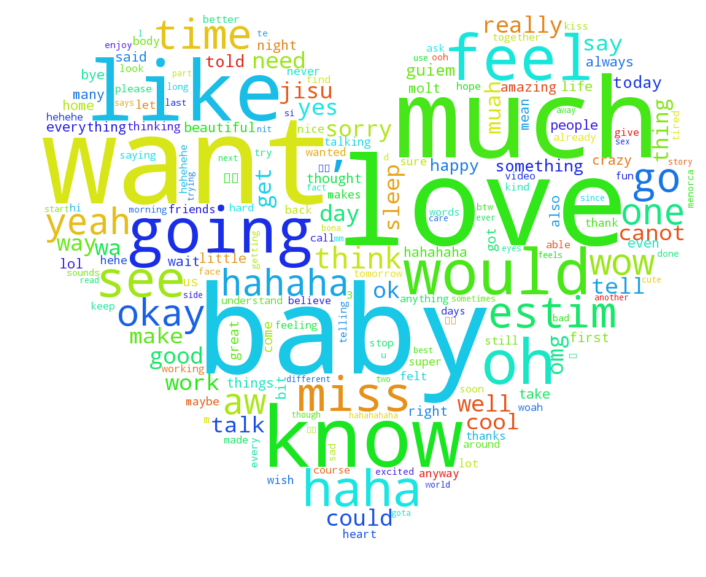

In [136]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.imshow(heart_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

In [108]:
# store to file because in the Jupyter notebook we cannot observe all the details
wc.to_file("./imgs/unigrams.png")

### Top 25

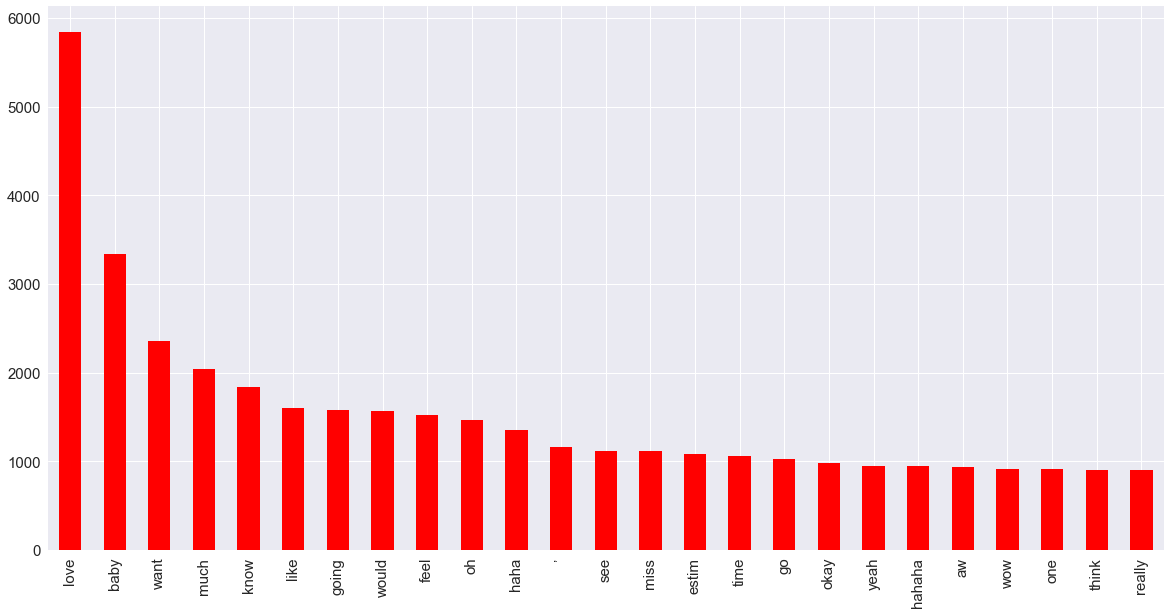

In [58]:
pd.Series(' '.join(df_with_text).split()).value_counts()[:25].plot(kind='bar',figsize=(20,10),color='r')

See the 12th most frequent word? It's the character __`__ instead of __'__. __She__ would use it all the time. My OCD would give me such a hard time with that specific character and I chose not to filter it so one can realize the magnitude of its use 😂 

#### Bigrams <a class="anchor" id="bigrams"></a>

For bigrams I prefer to have the information that's contained in the stop words. Why? Simple...

In [35]:
text = "I'm not happy"
print(normalize(text))

happy


The semantics just got lost! Thankfully we implemented our `normalize` function so it accepts a flag to tell we don't want to get rid of stop words.

In [39]:
text = "I'm not happy"
print(normalize(text,stops=False))

i am not happy


Also, we want to preserve the sentence structure so "_I am __happy. I__ like to sing._" does not consider `('happy','I')` as a bigram.

In [40]:
text = "I'm happy. I like to sing."
print(normalize(text,stops=False))

i am happy i like to sing


Another flag we added is our salvation!

In [44]:
text = "I'm happy. I like to sing."
print(normalize(text,stops=False,join_sentences=False))

[u'i am happy', u'i like to sing']


In [66]:
df['text_normalized_stop'] = df.text.apply(normalize,stops=False,join_sentences=False)

In [67]:
df_with_text_stop = df.text_normalized_stop.dropna()

In [65]:
text_bodies = []
for sentences in df_with_text_stop.values:
    for sentence in sentences:
        text_bodies.append(sentence)

In [66]:
len(text_bodies)

87043

In [96]:
vect = CountVectorizer(ngram_range=(2,2))
X = vect.fit_transform(text_bodies)
tot_occ = X.sum(axis=0) # counting total occurrences per token
df = pd.DataFrame(tot_occ, columns=vect.get_feature_names())
df_trans = df.transpose()
df_trans.columns = ['occurrences']
occs = df_trans.sort_values(by='occurrences',ascending=False)[:1000]

(-0.5, 1999.5, 999.5, -0.5)

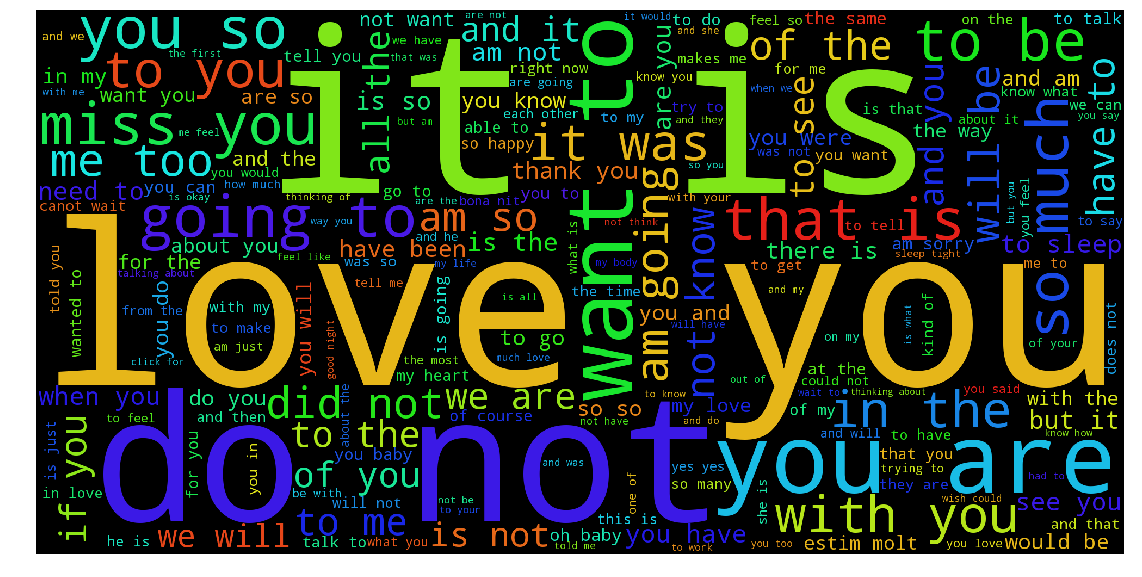

In [97]:
plt.figure(figsize=(20, 10))
wordcloud = WordCloud(background_color="black",width=2000, height=1000).fit_words(zip(occs[:1000].index,occs['occurrences'].tolist()))
plt.imshow(wordcloud)
plt.axis("off")

In [98]:
# store to file because in the Jupyter notebook we cannot observe all the details
wordcloud.to_file("./imgs/bigrams.png")

### Top 25

In [84]:
occs[:25]

,occurrences
love you,3263
it is,2476
do not,1933
you are,1664
want to,1396
going to,1296
so much,1211
to be,1090
miss you,954
that is,904


It turns out bigrams are not very informative. This is because I chose to get the stop words. Now we can observe something pretty obvious which is that stop words usually come in couples (_will be, of the, have to_). Let's find out if trigrams add the extra bit of informative content! (_**of the world**_ maybe?)

#### Trigrams <a class="anchor" id="trigrams"></a>

In [89]:
vect = CountVectorizer(ngram_range=(3,3))
X = vect.fit_transform(text_bodies)
tot_occ = X.sum(axis=0) # counting total occurrences per token
df = pd.DataFrame(tot_occ, columns=vect.get_feature_names())
df_trans = df.transpose()
df_trans.columns = ['occurrences']
occs = df_trans.sort_values(by='occurrences',ascending=False)[:1000]

(-0.5, 2999.5, 1999.5, -0.5)

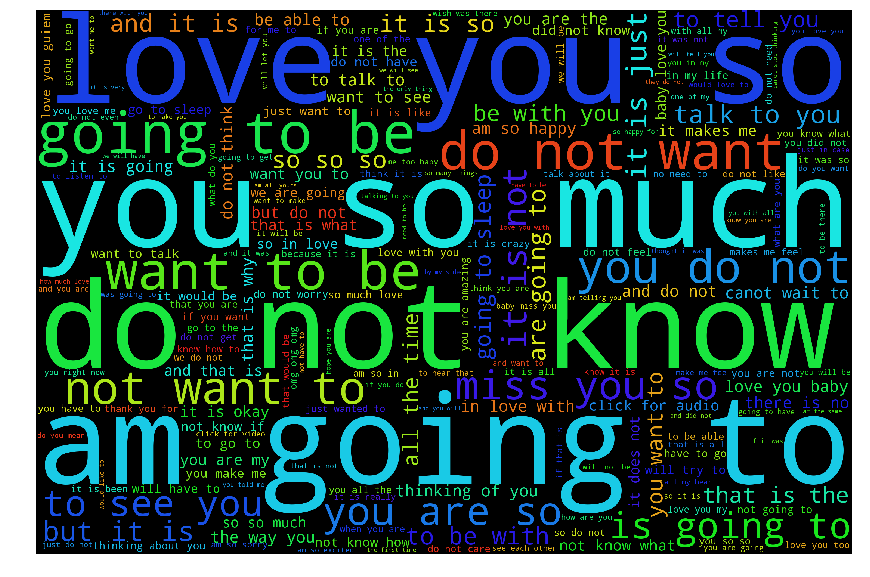

In [92]:
plt.figure(figsize=(20, 10))
wordcloud = WordCloud(background_color="black",width=3000, height=2000).fit_words(zip(occs[:1000].index,occs['occurrences'].tolist()))
plt.imshow(wordcloud)
plt.axis("off")

In [94]:
# store to file because in the Jupyter notebook we cannot observe all the details
wordcloud.to_file("./imgs/trigrams.png")

### Top 25

In [91]:
occs[:25]

,occurrences
you so much,643
am going to,540
love you so,461
do not know,434
going to be,252
do not want,249
want to be,216
you do not,214
not want to,212
miss you so,211


It is still full of meaningless forms like `and it is`. But it's interesting to observe how they could be grouped towards more meaningful topics.

"__you so__ much", "love __you so__", "miss __you so__" 

"want __to be__", "__to be__ with", "__be__ with you"


### Sentiment analysis <a class="anchor" id="sentiment"></a>

Due to effort economy we will use a trained model.

In [59]:
sentences = ["Guiem is smart, handsome, and funny.", "this is shit", "this is the shit"]

In [60]:
sid = SentimentIntensityAnalyzer()

In [62]:
for sentence in sentences:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    print(ss)

Guiem is smart, handsome, and funny.
{'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
this is shit
{'neg': 0.643, 'neu': 0.357, 'pos': 0.0, 'compound': -0.5574}
this is the shit
{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6124}


We define a function that can be easily applied to our dataframe.

In [63]:
def compound_senti(sentences,sid):
    if sentences and type(sentences) == type([]):
        compounds = []
        for sentence in sentences:
            compounds.append(sid.polarity_scores(sentence).get('compound'))
        return np.array(compounds).mean()
    else:
        return np.nan

In [64]:
compound_senti(sentences,sid)

0.29553333333333337

In [68]:
df['senti'] = df.text_normalized_stop.apply(compound_senti,sid=sid)

In [69]:
senti_days = df.groupby(pd.Grouper(key="datetime", freq='D'))['senti'].mean()

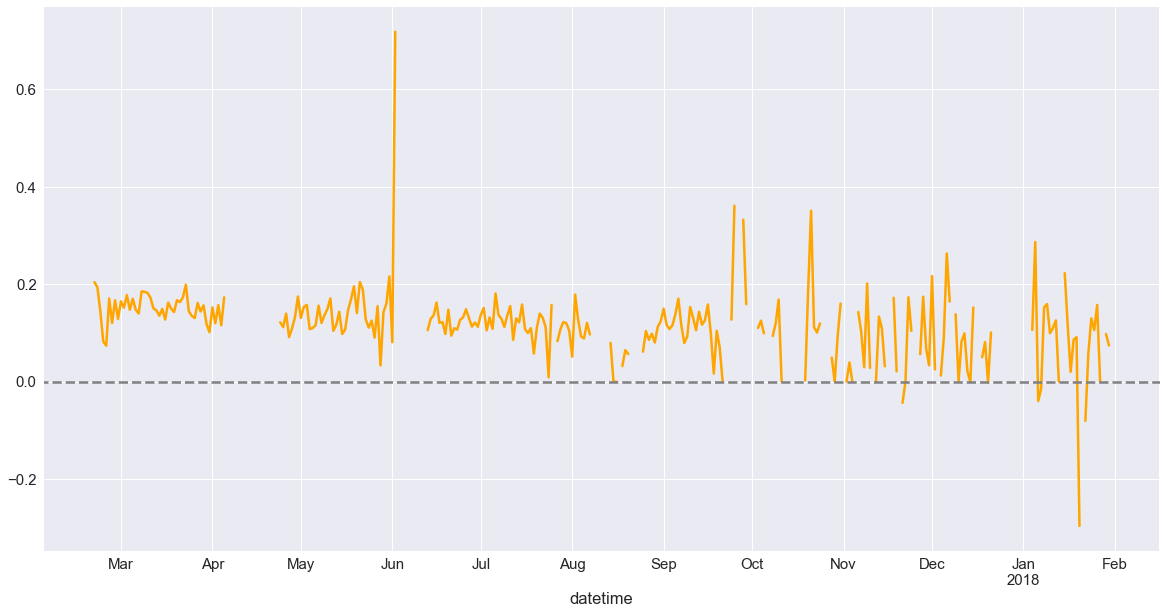

In [70]:
senti_days.plot(figsize=(20,10),color='orange')
plt.axhline(y=0.0, xmin=-1, xmax=1, hold=None,color='gray',linestyle='--')

In [168]:
senti_days.describe()

count    266.000000
mean       0.115426
std        0.075267
min       -0.296000
25%        0.091415
50%        0.119982
75%        0.149974
max        0.718400
Name: senti, dtype: float64

#### The happiest and the saddest messages!

Okaaay! What about checking out those peaks (max. positivie and max. negative) to see if the sentiment analyzer is doing its job?

In [175]:
senti_days.idxmax()

Timestamp('2017-06-02 00:00:00', offset='D')

In [195]:
df[(df.datetime >= '2017-06-02 00:00:00') & (df.datetime <= '2017-06-02 23:59:59')]

,user,date,text,source,datetime,text_normalized,text_normalized_stop,senti
932,Guiem Bosch,"Friday, June 2, 2017 at 6:40am UTC+01","t'estim, and now I have you here to experience...",facebook,2017-06-02 07:40:00,estim experience love togehter 😍,[t estim and now i have you here to experience...,0.7184
933,J.,"Friday, June 2, 2017 at 5:50am UTC+01",NaN,facebook,2017-06-02 06:50:00,NaN,NaN,NaN
934,J.,"Friday, June 2, 2017 at 5:20am UTC+01",NaN,facebook,2017-06-02 06:20:00,NaN,NaN,NaN


In [192]:
print(df.iloc[932].text)

t'estim, and now I have you here to experience this love with you, togehter 😍


Oh! Well, a little context here: we met by the end of February in Menorca. We spent only 2 days together and then she flew to Californa. She was crazy enough to buy tickets to come to Menorca again on 2nd June. The text corresponds to that day, when she arrived after 3 months of not seeing each other... (btw, "t'estim" means "I love you" Catalan).

In [176]:
senti_days.idxmin()

Timestamp('2018-01-20 00:00:00', offset='D')

In [199]:
df[(df.datetime >= '2018-01-20 00:00:00') & (df.datetime <= '2018-01-20 23:59:59')]

,user,date,text,source,datetime,text_normalized,text_normalized_stop,senti
36469,J.,1/20/18 16:24,Missed voice call,whatsapp,2018-01-20 16:24:00,missed voice call,[missed voice call],-0.296


Haha! It turns out that I filtered the "video chat" messages from Facebook because that's the platform we used for calls, but I forgot to filter WhatsApp 😅 . I'll leave it here as a funny example. Certainly a sad thing, a missed call! 😂

#### Word clouds by happiest and saddest messages

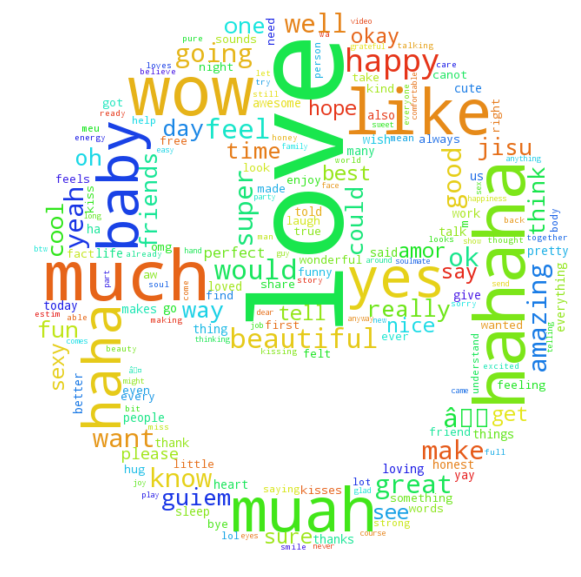

In [220]:
df_pos = df[df.senti>0.5].text_normalized.dropna()
top_1000 = pd.Series(' '.join(df_pos).split()).value_counts()[:1000]
happy_mask = np.array(Image.open("./imgs/happy.jpg"))
stopwords = set()
wc = WordCloud(background_color="white",mask=happy_mask,stopwords=stopwords)
wc.generate_from_frequencies(list(top_1000.to_dict().items()))
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()
# store to file because in the Jupyter notebook we cannot observe all the details
wc.to_file("./imgs/happyuni.png")

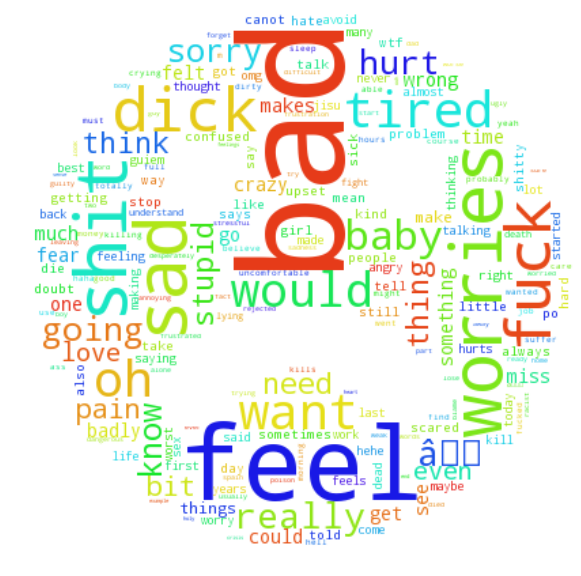

In [223]:
df_neg = df[df.senti<-0.5].text_normalized.dropna()
top_1000 = pd.Series(' '.join(df_neg).split()).value_counts()[:1000]
sad_mask = np.array(Image.open("./imgs/sad.jpg"))
stopwords = set()
wc = WordCloud(background_color="white",mask=sad_mask,stopwords=stopwords)
wc.generate_from_frequencies(list(top_1000.to_dict().items()))
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.axis("off")
plt.show()
# store to file because in the Jupyter notebook we cannot observe all the details
wc.to_file("./imgs/saduni.png")

#### Sentiment by week

In [71]:
senti_weeks = df.groupby(pd.Grouper(key="datetime", freq='W-MON'))['senti'].mean()

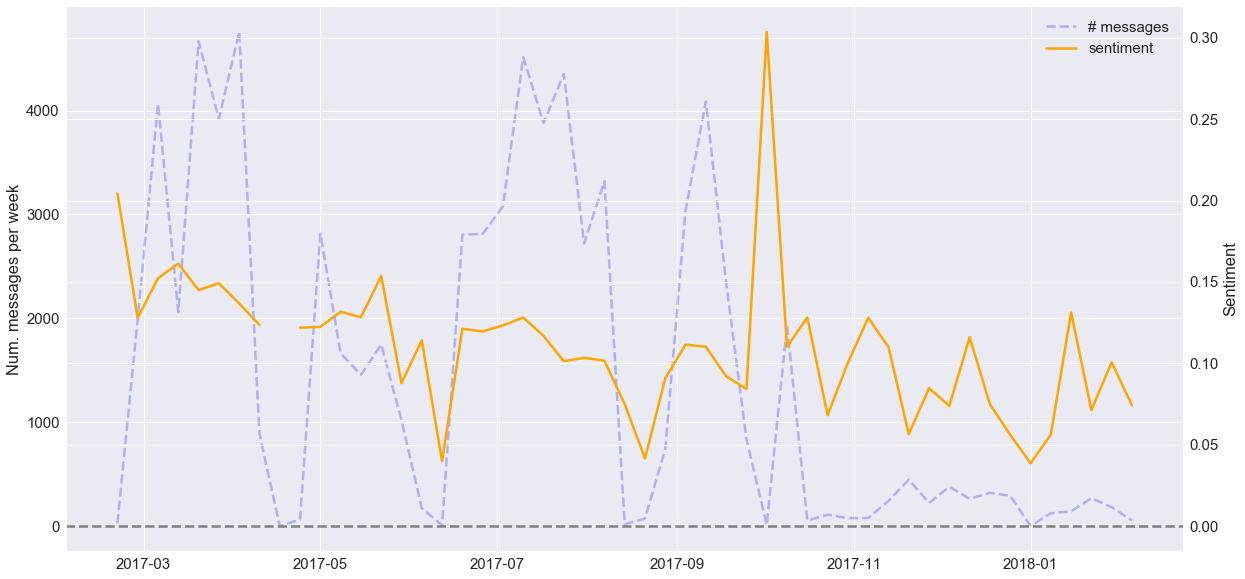

In [72]:
fig, ax = plt.subplots()
ax.plot(messages_week.text,'--',color='b',alpha=0.25,label='# messages')
ax.set_ylabel('Num. messages per week')
fig.set_size_inches(20,10)
ax2 = ax.twinx()
ax2.plot(senti_weeks,color='orange',label='sentiment')
ax2.set_ylabel('Sentiment')
lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='best')
plt.axhline(y=0.0, xmin=-1, xmax=1, hold=None,color='gray',linestyle='--')

### Topic detection <a class="anchor" id="topic"></a>

For topic detection I prefer to use a stemmer,  we will reduce topically similar words to their root so we don't see similar terms as separated entities. 

In [308]:
df['text_normalized_stemmer'] = df.text.apply(normalize,stops=True,join_sentences=False,stemmer=True)

In [309]:
df_stemmer_text = df[pd.notnull(df['text_normalized_stemmer'])]

In [310]:
text_months = df_stemmer_text.groupby(pd.Grouper(key="datetime", freq='M'))['text_normalized_stemmer'].apply(lambda x: x.sum())

Okay, what I'm going to do here is to use the Latent Dirichlet Allocation (LDA) and I'm gonna ask for 10 topics every month and described by 3 words. 

In [327]:
res = []
for month in text_months:
    texts = []
    for doc in month:
        doc_tokens = doc.split()
        texts.append(doc_tokens)
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
    res.append(ldamodel.print_topics(num_topics=10, num_words=3))

In [339]:
months = ['February','March','April','May','June','July','August','September','October','November','December','January',]
for idx,topics in enumerate(res):
    print(months[idx])
    for idx2,topic in enumerate(topics):
        print(idx2,''.join([i.replace('*','').replace('.','') for i in topic[1] if not i.isdigit()]))
    print('\n')

February
0 feel + tell + wa
1 think + time + okay
2 love + night + well
3 aw + like + would
4 go + sleep + ok
5 yeah + jisu + beauti
6 much + know + wow
7 lol + mean + say
8 come + crazi + thing
9 want + haha + right


March
0 know + thank + estim
1 wow + say + well
2 love + babi + want
3 talk + one + ye
4 feel + everyth + sorri
5 haha + aw + like
6 way + ok + let
7 much + love + see
8 go + jisu + could
9 hahaha + think + get


April
0 haha + yeah + fun
1 miss + need + much
2 know + okay + omg
3 babi + hahaha + good
4 love + aw + much
5 see + estim + play
6 ye + get + would
7 like + say + lol
8 want + pleas + oh
9 wow + ❤️ + crazi


May
0 babi + estim + go
1 time + think + get
2 like + would + say
3 work + yeah + way
4 love + canot + wait
5 jisu + haha + thank
6 want + know + well
7 good + thing + ye
8 realli + soon + cool
9 much + miss + oh


June
0 ’ + could + tell
1 okay + bye + would
2 go + much + work
3 love + omg + much
4 babi + oh + ok
5 want + feel + time
6 realli + like + mean

It's actually kind of cool. From the outsider observer it might seem really repetitive, and repetitive it is... indeed! But every month has its own subtleties. Anyway, maybe to refine a little bit more we could first remove the `N` most used words so we'd get rid of the all "I love you" and its variants. The hypothesis is that once we remove repetitive topics we would get to things more like "buy"+"tickets"+"soon" whenever we had to plan for the next trip, but I also want to preserve a little bit of privacy (believe me, I already explored deeper into the topics! 😏)

## Annex <a class="anchor" id="annex"></a>

### Normalize <a class="anchor" id="normalize"></a>

In [26]:
text = "So, you are departing around 21:00? It's sooo cooool, much excite. I can't wait!"

* Sentence tokenization

In [28]:
sentences = sent_tokenize(text)
print(sentences)

['So, you are departing around 21:00?', "It's sooo cooool, much excite.", "I can't wait!"]


* Some substitutions to avoid contraction problems, etc.

In [29]:
replacement_patterns = [
    (r'won\'t', 'will not'),
    (r'can\'t', 'cannot'),
    (r'i\'m', 'i am'),
    (r'ain\'t', 'is not'),
    (r'(\w+)\'ll', '\g<1> will'),
    (r'(\w+)n\'t', '\g<1> not'),
    (r'(\w+)\'ve', '\g<1> have'),
    (r'(\w+)\'s', '\g<1> is'),
    (r'(\w+)\'re', '\g<1> are'),
    (r'(\w+)\'d', '\g<1> would'),
    (r'gonna','going to'),
    (r'wanna','want to')
]
class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in
        patterns]
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
            (s, count) = re.subn(pattern, repl, s)
        return s

In [31]:
r = RegexpReplacer()
for idx,sentence in enumerate(sentences):
    sentences[idx] = r.replace(sentence)
print(sentences)

['So, you are departing around 21:00?', 'It is sooo cooool, much excite.', 'I cannot wait!']


* Word tokenization

In [32]:
tokenized = []
for sentence in sentences:
    tokenized.append(word_tokenize(sentence))
print(tokenized)

[['So', ',', 'you', 'are', 'departing', 'around', '21:00', '?'], ['It', 'is', 'sooo', 'cooool', ',', 'much', 'excite', '.'], ['I', 'can', 'not', 'wait', '!']]


* Eliminating punctuation

In [33]:
x = re.compile('[%s]' % re.escape(string.punctuation))

In [34]:
no_punct = [token for token in tokenized[2] if x.sub(u'', token)]
print(no_punct)

['I', 'can', 'not', 'wait']


* Conversion into lowercase

In [35]:
lowercase = [token.lower() for token in no_punct]
print(lowercase)

['i', 'can', 'not', 'wait']


* Stop words (optional, sometimes we want to keep the sentence structure)

In [36]:
stops = set(stopwords.words('english'))
no_stops = [word for word in lowercase if word not in stops]
print(no_stops)

['wait']


* Repeating characters (cases like 'happy' are respected, 'too' gets lost... but it's a stop word anyway!)

In [37]:
class RepeatReplacer(object):
    def __init__(self):
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
        self.repl = r'\1\2\3'
    def replace(self, word):
        if len(word) > 100:
            return ''
        if wordnet.synsets(word):
            return word
        repl_word = self.repeat_regexp.sub(self.repl, word)
        if repl_word != word:
            return self.replace(repl_word)
        else:
            return repl_word

In [38]:
replacer = RepeatReplacer()
replacer.replace('slapping')

'slapping'

In [52]:
def normalize(text, join_sentences = True, stops = True, stemmer = False):
    if type(text) not in [type(''),type(u'')]:
        return text
    r = RegexpReplacer()
    p_stemmer = PorterStemmer()
    word_punct_tokenizer = WordPunctTokenizer()
    repeat = RepeatReplacer()
    x = re.compile('[%s]' % re.escape(string.punctuation))
    if stops:
        stops = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    normalized_sentences = []
    for sentence in sentences:
        #tokens = word_tokenize(r.replace(sentence.lower()))
        tokens = word_punct_tokenizer.tokenize(r.replace(sentence.lower()))
        no_punct = [token for token in tokens if x.sub(u'', token)]
        no_repeat = [replacer.replace(word) for word in no_punct]
        if stops:
            no_repeat = [word for word in no_repeat if word not in stops]
        if stemmer:
            no_repeat = [p_stemmer.stem(word) for word in no_repeat]
        normalized_sentences.append(' '.join(no_repeat))
    if join_sentences:
        normalized_sentences = ' '.join(normalized_sentences)
        return normalized_sentences
    return [normalized_sentence for normalized_sentence in normalized_sentences]

In [53]:
text = "I'm not happy"
print(normalize(text,stops=False,stemmer=True))

i am not happi


### Other <a class="anchor" id="other"></a>

FB words per day.

In [97]:
df['words_in_text'] = df.text.apply(lambda x: len(str(x).split(' ')))

In [98]:
words_day = df.reset_index().set_index("datetime").groupby([pd.TimeGrouper('d')])["words_in_text"].sum()

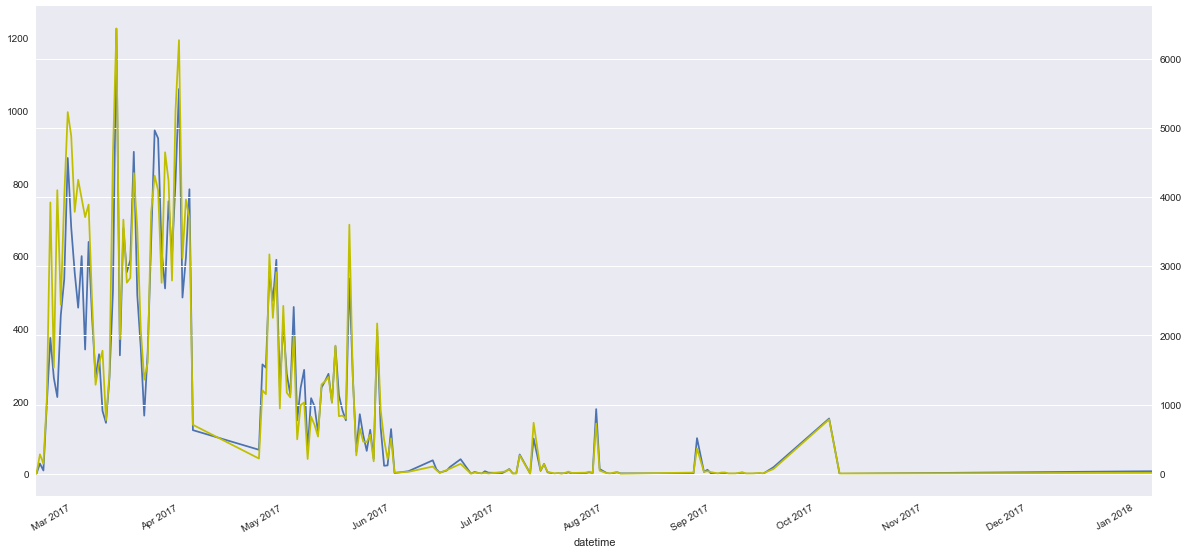

In [101]:
ax = messages_day.plot(figsize=(20,10))
words_day.plot(ax = ax,secondary_y=True,figsize=(20,10),style='y')

Let's zoom in for the first 3 months.

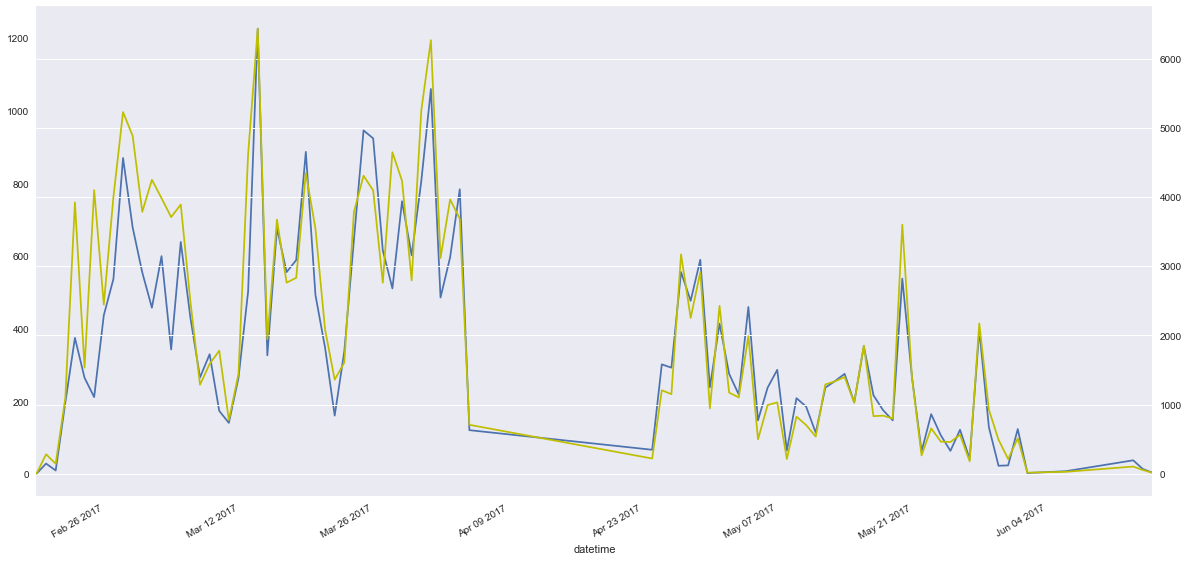

In [31]:
ax = messages_day[:90].plot(figsize=(20,10))
words_day[:90].plot(ax = ax,secondary_y=True,figsize=(20,10),style='y')